# Problématique

<h3> Prédire le nombre de lettres dans l'image (régression)</h3>

- Sample de 1000 observations (1000 mots) : charger (function preprocess (utiliser en sortie un .numpy() pour avoir des arrays), container toutes observations pour faire une matrice de taille (nb_observation, nb_features).
- Modèle Deep learning : MLP
- Évaluation du modèle : MAE métrique


# Import

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists

In [9]:
import letter_detection_utils as ld_util
from importlib import reload 
import warnings

# Ensure we have always the latest state and 
# not the last import in memory
reload(ld_util)

pickle_name = 'letter_detection_data'

# Chargement du dataframe

In [ ]:
img_size = (32, 128)
data = ld_util.get_dataframe_with_preprocessed_imgs(
    nb_rows=-1,
    pickle_name=pickle_name, 
    img_size=img_size,
    with_edge_detection = True
)

df = data['df']
preprocessed_imgs = data['preprocessed_imgs']

print("Length: ", len(df))
print("Imgs length: ", len(preprocessed_imgs))
print("Img shape: ", preprocessed_imgs[0].shape)

In [10]:
pickle_path = "../../pickle/" + pickle_name + ".pickle"
data = pickle.load(open(pickle_path, "rb"))
df = data['df']
preprocessed_imgs = data['preprocessed_imgs']

df.head(3)

,index,michelson_contrast,gray_level_mot,word_id,gray_level,x,y,w,h,transcription,word_img_path,form_img_path,length
0,944,0.758621,0.889522,a01-020u-06-05,170,1954,1831,389,100,studying,../data/words/a01/a01-020u/a01-020u-06-05.png,../data/formsA-D/a01-020u.png,8
1,914,0.695946,0.774799,a01-020u-02-06,169,1565,1129,128,49,has,../data/words/a01/a01-020u/a01-020u-02-06.png,../data/formsA-D/a01-020u.png,3
2,581,0.683168,0.830613,a01-011u-04-05,166,1622,1472,321,62,discuss,../data/words/a01/a01-011u/a01-011u-04-05.png,../data/formsA-D/a01-011u.png,7


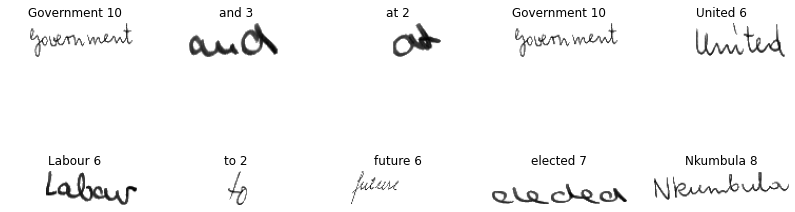

In [5]:
plt.figure(figsize=(14, 5))
j = 1
for i in np.random.randint(low=0, high=len(preprocessed_imgs), size=[10]):
    plt.subplot(2, 5, j)
    plt.axis('off')
    plt.imshow(preprocessed_imgs[i].reshape(img_size), cmap='gray');
    plt.title(df.iloc[i].transcription + ' ' + str(df.iloc[i].length))
    j+=1

# Data visualisation

Pour travailler avec les images et comparer le ratio hauteur/largeur, il faut au préalable rescale nos images.

In [6]:
df[['transcription', 'length', 'w', 'word_img_path', 'form_img_path']].sort_values(by=['w']).iloc[-3:]

,transcription,length,w,word_img_path,form_img_path
79,Independence,12,586,../data/words/a01/a01-011u/a01-011u-01-02.png,../data/formsA-D/a01-011u.png
627,Protectorate's,14,605,../data/words/a01/a01-014x/a01-014x-01-05.png,../data/formsA-D/a01-014x.png
15,demonstrations,14,640,../data/words/a01/a01-014x/a01-014x-06-02.png,../data/formsA-D/a01-014x.png


In [7]:
df[['transcription', 'length', 'w', 'word_img_path', 'form_img_path']].sort_values(by=['w']).iloc[:3]

,transcription,length,w,word_img_path,form_img_path
148,A,1,27,../data/words/a01/a01-000u/a01-000u-00-00.png,../data/formsA-D/a01-000u.png
673,is,2,30,../data/words/a01/a01-000x/a01-000x-01-05.png,../data/formsA-D/a01-000x.png
441,a,1,32,../data/words/a01/a01-000x/a01-000x-01-10.png,../data/formsA-D/a01-000x.png


Hypothèse: le nombre de caractère est proportionnel à la largeur des boîtes.

In [8]:
df['length'].describe()

count    1000.00000
mean        4.84800
std         2.48658
min         1.00000
25%         3.00000
50%         4.00000
75%         7.00000
max        15.00000
Name: length, dtype: float64

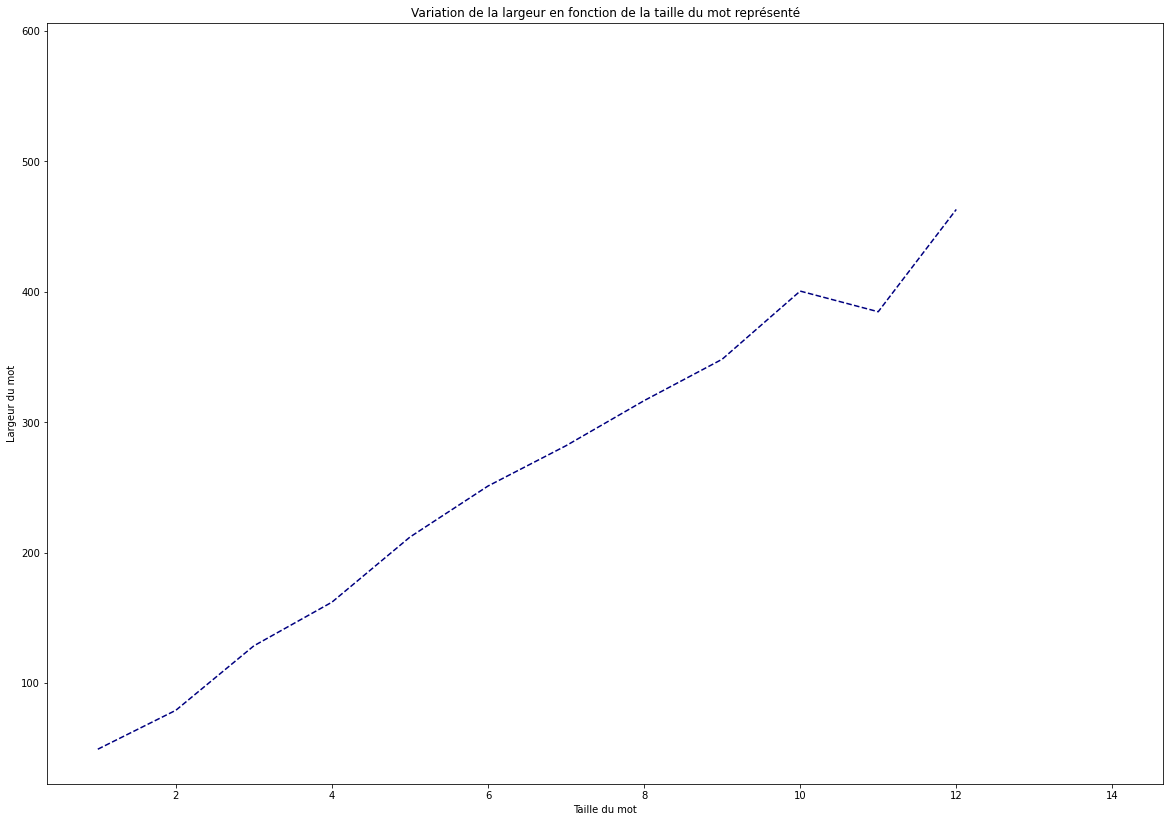

In [9]:
ld_util.plot_avg_width_per_string_length(df)

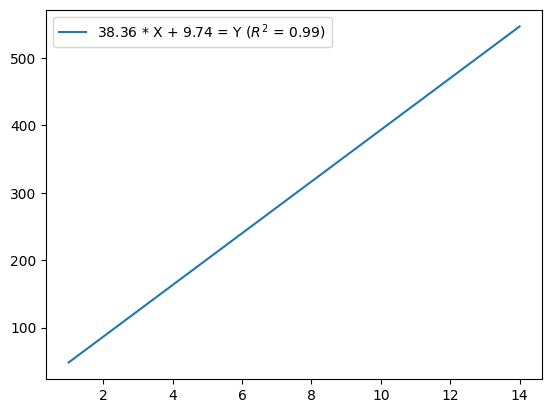

In [22]:
from sklearn.linear_model import LinearRegression
import numpy as np
import math

biggest_word_size = df['length'].max()
reg_x = []
reg_y = []

width_means = []
for l in range(1, 15):
    m = df[df['length'] == l].w.mean()
    if not math.isnan(m):
        reg_x.append(l)
        reg_y.append(m)

reg_x = np.array(reg_x).reshape(-1, 1)
reg_y = np.array(reg_y).reshape(-1, 1)
reg = LinearRegression().fit(reg_x, reg_y)
score = reg.score(reg_x, reg_y)

print()

f_legend ="{} * X + {} = Y ($R^2$ = {})".format(reg.coef_[0][0].round(2), reg.intercept_[0].round(2), score.round(2))
plt.plot(reg_x, reg.predict(reg_x), label=f_legend)
plt.legend();


# Model

## Linear

In [10]:
from sklearn.model_selection import train_test_split

X_lin_train, X_lin_test, y_lin_train, y_lin_test = train_test_split(df[['w']], df['length'], test_size=0.2)

In [11]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_lin_train, y_lin_train)
score = lr.score(X_lin_test, y_lin_test)
y_lin_test_pred = lr.predict(X_lin_test)

print("Score: ", score)

Score:  0.820654687983935


In [12]:
lr.coef_

array([0.02127271])

In [9]:
lr.intercept_

0.036973991201704415

In [13]:
lr.coef_[0]

0.02127270968334295

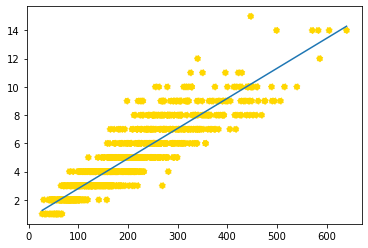

In [19]:
xmin = df.w.min()
xmax = df.w.max()
X = np.linspace(xmin, xmax, 1000)
y = X * lr.coef_[0] + lr.intercept_
plt.plot(X, y);
plt.scatter(df['w'], df['length'], ls='dotted', color='gold');